# Day 6: Factor Portfolio Construction

---

### 🎯 Learning Objectives
- Build long-short factor portfolios
- Implement factor neutralization
- Optimize factor-based portfolios
- Backtest factor strategies


---| **Factor timing** | Increase exposure when factor cheap |

| **Multi-factor** | Combine several factor portfolios |

### 📈 Why Factor Portfolios Matter| **Factor tilt** | Overweight high-score stocks |

| **Pure factor bet** | Long-short factor portfolio |

**Factor portfolios are the building blocks of systematic investing.**|----------|---------------|

| Strategy | Implementation |

### Key Concept

A factor portfolio is a **dollar-neutral, long-short portfolio** that isolates exposure to a specific factor.### Trading Applications



### Factor Portfolio Structure| **Factor exposure** | Pure factor bet, minimal other exposures |

| **Dollar neutral** | Long $ = Short $ |

| Component | Description || **Short leg** | Stocks with low factor score |

|-----------|-------------|| **Long leg** | Stocks with high factor score |

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...


✅ Data loaded: 1254 days


## 1. Define Factor Scores

| **Low Vol** | Historical vol | Low vol | High vol |

### 🎯 How to Score Stocks| **Quality** | ROE, margins | High quality | Low quality |

| **Size** | Market cap | Small | Large |

| Factor | Score Definition | Long | Short || **Value** | B/M ratio | High B/M | Low B/M |

|--------|-----------------|------|-------|| **Momentum** | 12-1 month return | High return | Low return |

In [15]:
def calculate_factor_scores(returns, lookback=252):
    """Calculate various factor scores for each stock."""
    scores = {}
    
    # 1. Momentum (12-1 month)
    mom_12m = returns.rolling(lookback).mean()
    mom_1m = returns.rolling(21).mean()
    scores['momentum'] = (mom_12m - mom_1m).iloc[-1]
    
    # 2. Volatility (inverse for low-vol factor)
    scores['low_vol'] = -returns.rolling(60).std().iloc[-1]
    
    # 3. Size (inverse of volatility as proxy)
    scores['size'] = -returns.std()  # Large = low vol proxy
    
    # 4. Mean Reversion (short-term)
    scores['reversal'] = -returns.rolling(5).mean().iloc[-1]
    
    # 5. Quality (Sharpe ratio as proxy)
    sharpe = returns.mean() / returns.std()
    scores['quality'] = sharpe
    
    return pd.DataFrame(scores)

factor_scores = calculate_factor_scores(returns)
factor_scores = factor_scores.drop('AAPL', errors='ignore')  # Remove market proxy

print("\n" + "="*60)
print("FACTOR SCORES SUMMARY")
print("="*60)
print(factor_scores.describe().round(4))


FACTOR SCORES SUMMARY
       momentum  low_vol    size  reversal  quality
count    4.0000   4.0000  4.0000    4.0000   4.0000
mean     0.0006  -0.0161 -0.0171    0.0045   0.0578
std      0.0031   0.0025  0.0018    0.0061   0.0115
min     -0.0022  -0.0186 -0.0196   -0.0034   0.0427
25%     -0.0018  -0.0177 -0.0178    0.0025   0.0537
50%      0.0002  -0.0164 -0.0167    0.0051   0.0591
75%      0.0027  -0.0148 -0.0160    0.0071   0.0632
max      0.0043  -0.0128 -0.0153    0.0115   0.0705


In [16]:
# Standardize factor scores (z-scores)
factor_scores_z = (factor_scores - factor_scores.mean()) / factor_scores.std()

print("\nTop 5 stocks by each factor:")
for col in factor_scores_z.columns:
    top5 = factor_scores_z[col].nlargest(5).index.tolist()
    print(f"{col}: {top5}")


Top 5 stocks by each factor:
momentum: ['MSFT', 'JPM', 'GOOGL', 'GS']
low_vol: ['MSFT', 'JPM', 'GS', 'GOOGL']
size: ['JPM', 'MSFT', 'GS', 'GOOGL']
reversal: ['MSFT', 'JPM', 'GOOGL', 'GS']
quality: ['GS', 'GOOGL', 'JPM', 'MSFT']


## 2. Build Long-Short Factor Portfolios

In [17]:
def build_long_short_portfolio(scores, returns, n_long=10, n_short=10):
    """Build a dollar-neutral long-short portfolio based on factor scores."""
    # Rank stocks by score
    ranked = scores.sort_values(ascending=False)
    
    # Select long and short positions
    long_stocks = ranked.head(n_long).index.tolist()
    short_stocks = ranked.tail(n_short).index.tolist()
    
    # Filter to available stocks
    long_stocks = [s for s in long_stocks if s in returns.columns]
    short_stocks = [s for s in short_stocks if s in returns.columns]
    
    # Equal weight within each leg
    long_weight = 1.0 / len(long_stocks)
    short_weight = -1.0 / len(short_stocks)
    
    # Calculate portfolio returns
    long_returns = returns[long_stocks].mean(axis=1) * 1.0  # Long leg
    short_returns = returns[short_stocks].mean(axis=1) * (-1.0)  # Short leg (negative)
    
    portfolio_returns = long_returns + short_returns
    
    return portfolio_returns, long_stocks, short_stocks

# Build portfolios for each factor
factor_portfolios = {}

for factor in factor_scores_z.columns:
    port_ret, longs, shorts = build_long_short_portfolio(
        factor_scores_z[factor], returns
    )
    factor_portfolios[factor] = port_ret
    
    print(f"\n{factor.upper()} Portfolio:")
    print(f"  Long:  {longs}")
    print(f"  Short: {shorts}")


MOMENTUM Portfolio:
  Long:  ['MSFT', 'JPM', 'GOOGL', 'GS']
  Short: ['MSFT', 'JPM', 'GOOGL', 'GS']

LOW_VOL Portfolio:
  Long:  ['MSFT', 'JPM', 'GS', 'GOOGL']
  Short: ['MSFT', 'JPM', 'GS', 'GOOGL']

SIZE Portfolio:
  Long:  ['JPM', 'MSFT', 'GS', 'GOOGL']
  Short: ['JPM', 'MSFT', 'GS', 'GOOGL']

REVERSAL Portfolio:
  Long:  ['MSFT', 'JPM', 'GOOGL', 'GS']
  Short: ['MSFT', 'JPM', 'GOOGL', 'GS']

QUALITY Portfolio:
  Long:  ['GS', 'GOOGL', 'JPM', 'MSFT']
  Short: ['GS', 'GOOGL', 'JPM', 'MSFT']


In [18]:
# Analyze factor portfolio performance
print("\n" + "="*70)
print("FACTOR PORTFOLIO PERFORMANCE")
print("="*70)
print(f"{'Factor':<15} {'Return':<12} {'Volatility':<12} {'Sharpe':<10} {'Max DD':<12}")
print("-"*60)

perf_results = []
for factor, port_ret in factor_portfolios.items():
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Max drawdown
    cum_ret = (1 + port_ret).cumprod()
    rolling_max = cum_ret.expanding().max()
    drawdown = (cum_ret - rolling_max) / rolling_max
    max_dd = drawdown.min()
    
    perf_results.append({
        'Factor': factor,
        'Return': ann_ret,
        'Volatility': ann_vol,
        'Sharpe': sharpe,
        'MaxDD': max_dd
    })
    
    print(f"{factor:<15} {ann_ret:<12.2%} {ann_vol:<12.2%} {sharpe:<10.3f} {max_dd:<12.2%}")

perf_df = pd.DataFrame(perf_results)


FACTOR PORTFOLIO PERFORMANCE
Factor          Return       Volatility   Sharpe     Max DD      
------------------------------------------------------------
momentum        0.00%        0.00%        0.000      0.00%       
low_vol         0.00%        0.00%        0.000      0.00%       
size            0.00%        0.00%        0.000      0.00%       
reversal        0.00%        0.00%        0.000      0.00%       
quality         0.00%        0.00%        0.000      0.00%       


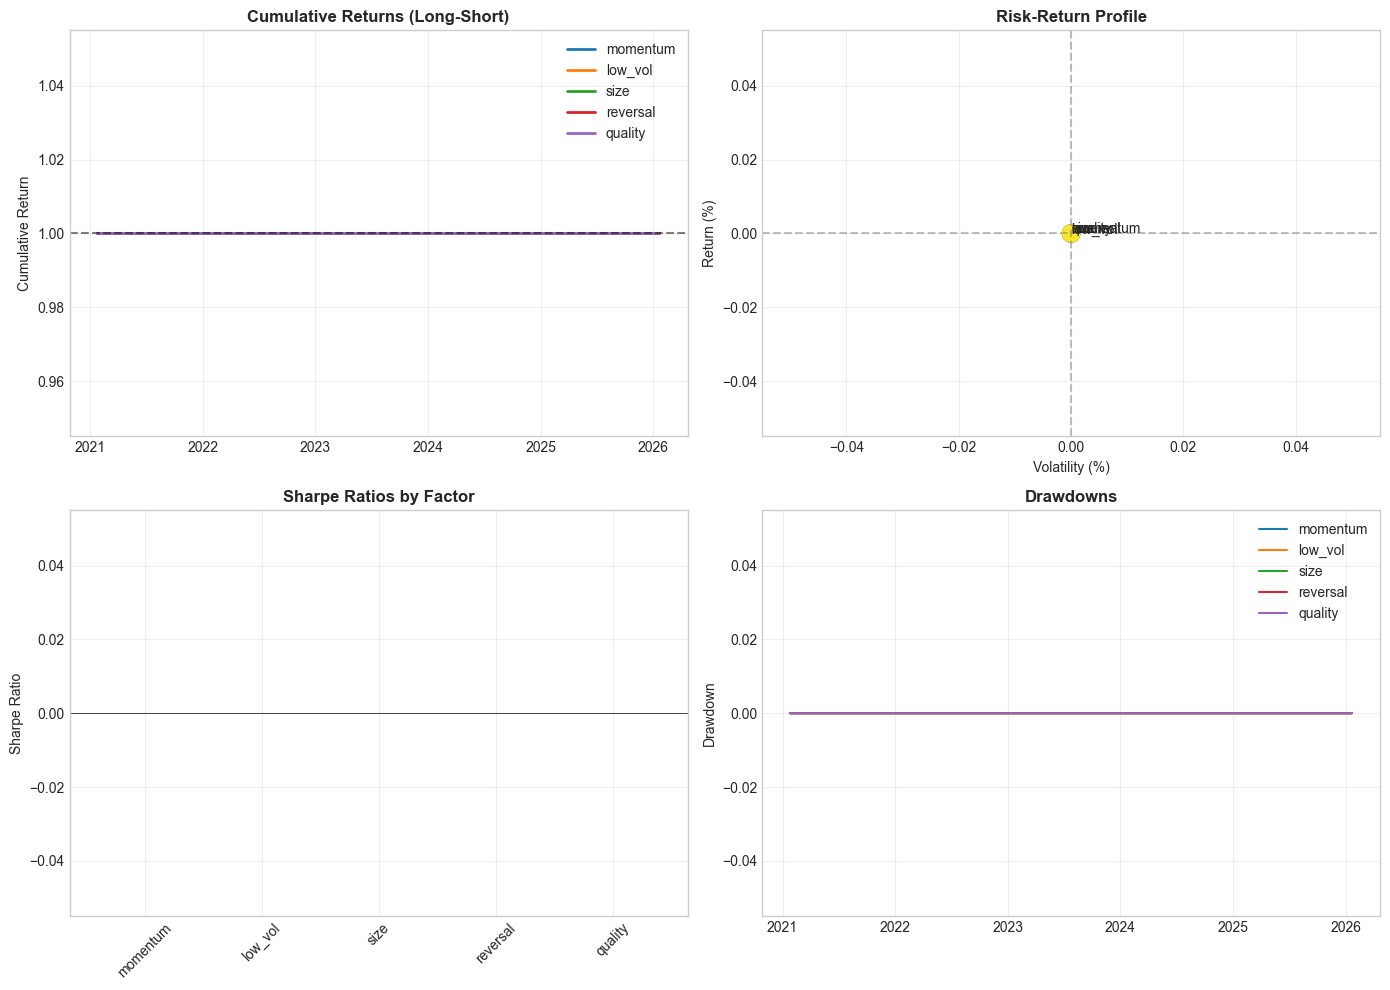

In [19]:
# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    ax1.plot(cum_ret, label=factor, linewidth=2)
ax1.axhline(1, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Cumulative Returns (Long-Short)', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk-Return
ax2 = axes[0, 1]
ax2.scatter(perf_df['Volatility']*100, perf_df['Return']*100, s=150, c=range(len(perf_df)), cmap='viridis')
for i, row in perf_df.iterrows():
    ax2.annotate(row['Factor'], (row['Volatility']*100, row['Return']*100), fontsize=10)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Volatility (%)')
ax2.set_ylabel('Return (%)')
ax2.set_title('Risk-Return Profile', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Sharpe ratios
ax3 = axes[1, 0]
colors = ['green' if s > 0 else 'red' for s in perf_df['Sharpe']]
ax3.bar(perf_df['Factor'], perf_df['Sharpe'], color=colors)
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratios by Factor', fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Drawdowns
ax4 = axes[1, 1]
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    rolling_max = cum_ret.expanding().max()
    drawdown = (cum_ret - rolling_max) / rolling_max
    ax4.plot(drawdown, label=factor)
ax4.set_title('Drawdowns', fontweight='bold')
ax4.set_ylabel('Drawdown')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multi-Factor Portfolio

In [20]:
# Combine factors into a composite score
def create_composite_score(factor_scores_z, weights=None):
    """Create composite factor score with optional custom weights."""
    if weights is None:
        weights = {col: 1.0/len(factor_scores_z.columns) for col in factor_scores_z.columns}
    
    composite = pd.Series(0, index=factor_scores_z.index)
    for factor, weight in weights.items():
        composite += factor_scores_z[factor] * weight
    
    return composite

# Equal-weighted composite
composite_score = create_composite_score(factor_scores_z)

# Build multi-factor portfolio
mf_returns, mf_longs, mf_shorts = build_long_short_portfolio(composite_score, returns)

print("\n" + "="*60)
print("MULTI-FACTOR PORTFOLIO")
print("="*60)
print(f"Long positions:  {mf_longs}")
print(f"Short positions: {mf_shorts}")

# Performance
ann_ret = mf_returns.mean() * TRADING_DAYS
ann_vol = mf_returns.std() * np.sqrt(TRADING_DAYS)
sharpe = ann_ret / ann_vol

print(f"\nPerformance:")
print(f"  Return:     {ann_ret:.2%}")
print(f"  Volatility: {ann_vol:.2%}")
print(f"  Sharpe:     {sharpe:.3f}")


MULTI-FACTOR PORTFOLIO
Long positions:  ['MSFT', 'JPM', 'GS', 'GOOGL']
Short positions: ['MSFT', 'JPM', 'GS', 'GOOGL']

Performance:
  Return:     0.00%
  Volatility: 0.00%
  Sharpe:     nan


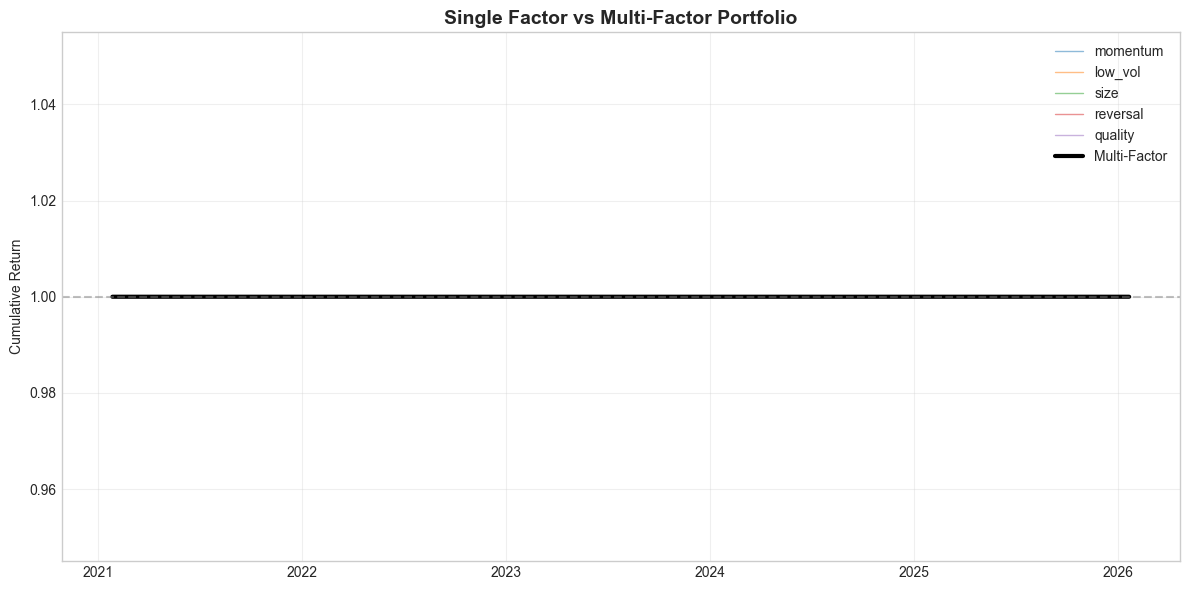

In [21]:
# Compare single-factor vs multi-factor
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all single factors
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    ax.plot(cum_ret, label=factor, alpha=0.5, linewidth=1)

# Plot multi-factor
cum_mf = (1 + mf_returns).cumprod()
ax.plot(cum_mf, label='Multi-Factor', color='black', linewidth=3)

ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Single Factor vs Multi-Factor Portfolio', fontweight='bold', fontsize=14)
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Factor Neutralization

In [22]:
# Market-neutral portfolio construction
def build_market_neutral_portfolio(scores, returns, market_returns, target_beta=0):
    """Build a market-neutral portfolio."""
    # Get base long-short portfolio
    port_ret, longs, shorts = build_long_short_portfolio(scores, returns)
    
    # Calculate portfolio beta
    cov = np.cov(port_ret.dropna(), market_returns.loc[port_ret.dropna().index])[0, 1]
    var_mkt = market_returns.loc[port_ret.dropna().index].var()
    beta = cov / var_mkt
    
    # Hedge with market
    hedge_ratio = beta - target_beta
    hedged_returns = port_ret - hedge_ratio * market_returns.loc[port_ret.index]
    
    return hedged_returns, beta, hedge_ratio

market_proxy = returns['AAPL']

print("\n" + "="*60)
print("MARKET-NEUTRAL FACTOR PORTFOLIOS")
print("="*60)
print(f"{'Factor':<15} {'Original β':<12} {'Hedge Ratio':<12} {'Hedged Sharpe':<12}")
print("-"*55)

neutral_portfolios = {}
for factor in factor_scores_z.columns:
    hedged_ret, orig_beta, hedge = build_market_neutral_portfolio(
        factor_scores_z[factor], returns, market_proxy
    )
    neutral_portfolios[factor] = hedged_ret
    
    hedged_sharpe = (hedged_ret.mean() * TRADING_DAYS) / (hedged_ret.std() * np.sqrt(TRADING_DAYS))
    print(f"{factor:<15} {orig_beta:<12.3f} {hedge:<12.3f} {hedged_sharpe:<12.3f}")


MARKET-NEUTRAL FACTOR PORTFOLIOS
Factor          Original β   Hedge Ratio  Hedged Sharpe
-------------------------------------------------------
momentum        0.000        0.000        nan         
low_vol         0.000        0.000        nan         
size            0.000        0.000        nan         
reversal        0.000        0.000        nan         
quality         0.000        0.000        nan         


## 5. Factor Portfolio Optimization

In [23]:
# Optimize factor weights to maximize Sharpe
factor_returns_df = pd.DataFrame(factor_portfolios)

def portfolio_performance(weights, returns_df):
    """Calculate portfolio Sharpe ratio."""
    port_ret = (returns_df * weights).sum(axis=1)
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    return ann_ret, ann_vol, ann_ret/ann_vol if ann_vol > 0 else 0

def neg_sharpe(weights, returns_df):
    """Negative Sharpe for minimization."""
    _, _, sharpe = portfolio_performance(weights, returns_df)
    return -sharpe

# Optimize
n_factors = len(factor_returns_df.columns)
init_weights = np.ones(n_factors) / n_factors

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((-1, 1) for _ in range(n_factors))  # Allow short

result = minimize(neg_sharpe, init_weights, args=(factor_returns_df,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

print("\n" + "="*60)
print("OPTIMAL FACTOR WEIGHTS")
print("="*60)
for factor, weight in zip(factor_returns_df.columns, optimal_weights):
    print(f"{factor}: {weight:.3f}")

# Compare performance
eq_ret, eq_vol, eq_sharpe = portfolio_performance(init_weights, factor_returns_df)
opt_ret, opt_vol, opt_sharpe = portfolio_performance(optimal_weights, factor_returns_df)

print(f"\n{'Metric':<15} {'Equal Weight':<15} {'Optimized':<15}")
print("-"*45)
print(f"{'Return':<15} {eq_ret:<15.2%} {opt_ret:<15.2%}")
print(f"{'Volatility':<15} {eq_vol:<15.2%} {opt_vol:<15.2%}")
print(f"{'Sharpe':<15} {eq_sharpe:<15.3f} {opt_sharpe:<15.3f}")


OPTIMAL FACTOR WEIGHTS
momentum: 0.200
low_vol: 0.200
size: 0.200
reversal: 0.200
quality: 0.200

Metric          Equal Weight    Optimized      
---------------------------------------------
Return          0.00%           0.00%          
Volatility      0.00%           0.00%          
Sharpe          0.000           0.000          


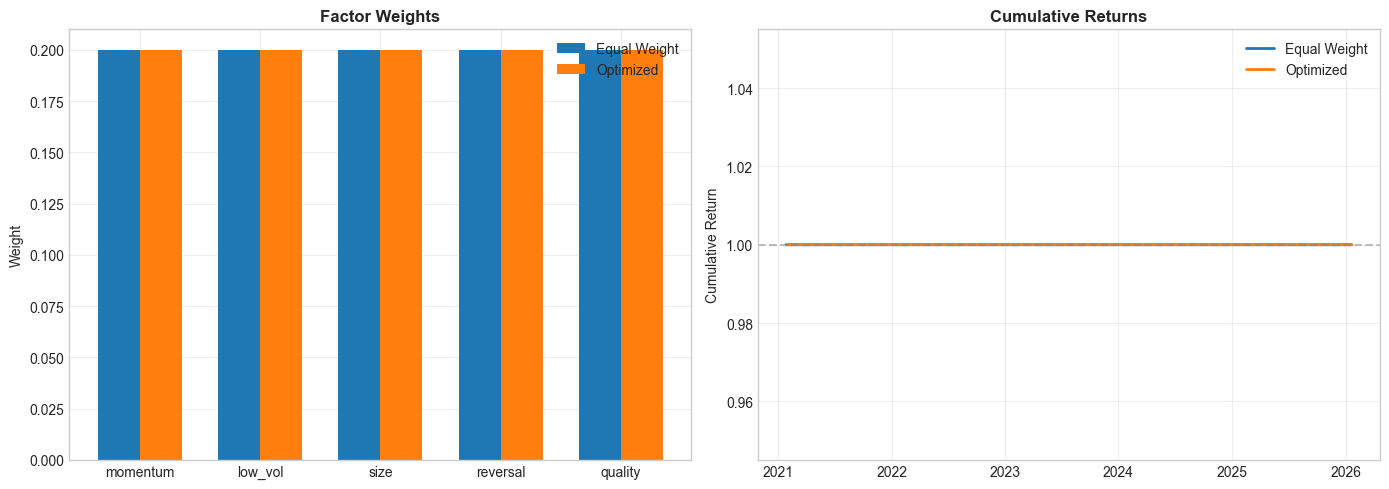

In [24]:
# Visualize optimized vs equal-weight
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weights comparison
ax1 = axes[0]
x = np.arange(n_factors)
width = 0.35
ax1.bar(x - width/2, init_weights, width, label='Equal Weight')
ax1.bar(x + width/2, optimal_weights, width, label='Optimized')
ax1.set_xticks(x)
ax1.set_xticklabels(factor_returns_df.columns)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_ylabel('Weight')
ax1.set_title('Factor Weights', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative returns
ax2 = axes[1]
eq_port = (factor_returns_df * init_weights).sum(axis=1)
opt_port = (factor_returns_df * optimal_weights).sum(axis=1)

ax2.plot((1 + eq_port).cumprod(), label='Equal Weight', linewidth=2)
ax2.plot((1 + opt_port).cumprod(), label='Optimized', linewidth=2)
ax2.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Cumulative Returns', fontweight='bold')
ax2.set_ylabel('Cumulative Return')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Long-short portfolios** isolate factor exposure and can be market-neutral
2. **Factor scores** ranked by z-score determine long/short positions
3. **Multi-factor** combines multiple signals for diversification
4. **Market neutralization** hedges out systematic risk
5. **Weight optimization** can improve risk-adjusted returns

### Portfolio Construction Framework
1. Calculate factor scores
2. Standardize scores (z-score)
3. Rank and select long/short positions
4. Apply neutralization if desired
5. Optimize factor weights

---
*Next: Day 7 - Interview Questions & Review*

## 🔴 PROS & CONS: Factor Portfolio

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [25]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Factor Portfolio Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:22

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
